In [1]:
import numpy as np

from sklearn.cluster import DBSCAN, AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from random import randrange
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
import matplotlib
from itertools import cycle
import numpy as np
import random
import csv
import json
from pprint import pprint
import dateutil.parser
from statistics import mean

In [2]:
# Read json logs
def read_json(json_logs_path):
    data = []
    # Open Json
    for line in open(json_logs_path, 'r'):
        data.append(json.loads(line))
    parsed = json.loads(json.dumps(data))
    print(parsed[0])
    return parsed

#Parse json and extract variables variables
def parse_json(data):
    days = []
    times = []
    ids = []
    intents = []
    params = []
    #parse each json variable
    for i in range(len(data)):
        datetime_object = dateutil.parser.parse(data[i]["datetime"])
        # Extract day of week
        my_day = date_to_days(datetime_object)
        days.append(my_day)
        # Extract hour of day
        my_hour = time_to_hours(datetime_object)
        times.append(my_hour)
        # Extract intents
        my_id = str(data[i]["type"])+(str(data[i]["parameters"]))
        m_param = str(data[i]["parameters"])
        ids.append(my_id)
        my_intent = str(data[i]["type"])
        intents.append(my_intent)
        my_param = str(data[i]["parameters"])
        params.append(my_param)
    X = np.array((days,times,ids,intents, params))
    X = X.transpose()
    print(X.shape)
    return X

def extract_ids(data):
    unique_ids = np.unique(data)
    return unique_ids

In [3]:
# Date generation functions
def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)


def date_to_days(date):
    """
    This function returns day of week in range 1-10
    """
    day_t = (float(date.day) *10.0)/31.0
    return day_t

def time_to_seconds(date):
    """
    Function returns time of the day in seconds"""
    td = date.time()
    return ((td.hour * 3600 + td.second) * 10**6 + td.microsecond) / 10**6

def time_to_hours(date):
    """
    Function returns time of the day in hours in range 1-10"""
    td = date.time()
    td_t = (float(td.hour) * 10.0)/24.0
    return float(td_t)


In [4]:
# Generate data
# colors
def gen_colors(n):
  ret = []
  r = int(random.random()*10)/10
  g = int(random.random()*10)/10
  b = int(random.random()*10)/10
  step = 256 / n
  for i in range(n):
    r += i*0.01
    g += i*0.01
    b += i*0.01
    r = (r)%1
    g = (g)%1
    b = (b)%1
    ret.append((r,g,b)) 
  return ret


# ONLY FOR TESTING
#Sample blobs
def gen_blobs(nb_points):
    centers = [[1, 1], [-1, -1], [1, -1]]
    X, labels_true = make_blobs(n_samples=nb_points, centers=centers, cluster_std=0.5,
                            random_state=0)
    return X, labels_true

#Sample dates,times
def gen_dt(nb_points):
    #Sample periods 
    start1 = datetime(1943,3, 13, 19,40,6)
    end1 = start1 + timedelta(days=100)
    
    start2 = datetime(1943,5, 15, 20,43,6)
    end2 = start2 + timedelta(days=200)
    
    start3 = datetime(1942,8, 25, 1,1,1)
    end3 = start3 + timedelta(days=300)
    
    start4 = datetime(1944,5, 3, 18,1,1)
    end4 = start4 + timedelta(days=110)
    
    #init arrays
    days = []
    times = []
    intents = []
    #sample intents that represent commands logged
    unique_intents = ['3716866579841658294:JokingIntent','1724922955324666750:CurrentWeatherIntent'
              ,'4253483654314684618:Atom','1546735819467345818:Firefox']
    #Generate datetimes 
    for i in range(int(nb_points*30/100)):
        random_dt1 = random_date(start1, end1)
        days.append(date_to_days(random_dt1))
        times.append(time_to_hours(random_dt1))
    for i in range(int(nb_points*25/100)):
        random_dt2 = random_date(start2, end2)
        days.append(date_to_days(random_dt2))
        times.append(time_to_hours(random_dt2)) 
    for i in range(int(nb_points*25/100)):
        random_dt3 = random_date(start3, end3)
        days.append(date_to_days(random_dt3))
        times.append(time_to_hours(random_dt3)%5+10)
    for i in range(int(nb_points*20/100)):
        random_dt2 = random_date(start4, end4)
        days.append(date_to_days(random_dt2))
        times.append(time_to_hours(random_dt2)) 
    
    for i in range(nb_points):
        intents.append(random.choice(unique_intents))
    #X = days,times , intents
    X = np.array((days,times,intents))
    #X = X.reshape(n_samples,2)
    X = X.transpose()
    print(X.shape)
    return X

In [5]:
# Print informations for testing
def print_clusters(features,core_samples_mask_dbscan, labels_dbscan):
    xy = features
    print("nb points")
    print((features.shape))
    print("X:")
    print(xy[:, 0])
    print("Y:")
    print(xy[:, 1])
    print("labels")
    print(labels_dbscan.shape)
    print(labels_dbscan)
    print("commands")
    print(xy[:,2])
    
# Write points to a csv file
def write_points(features, labels_dbscan):

    with open('clusters.csv', 'w') as csvfile:
        fieldnames = ['x', 'y','cluster','intent']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for val, cluster in zip(features, labels_dbscan):
            writer.writerow({'x': val[0], 'y': val[1],'cluster':cluster,'intent':val[2]})

# Write metadata
def write_metadata(labels_dbscan):
    n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
    with open('metadata.csv', 'w') as csvfile:
        fieldnames = ['keys','values']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerow({'keys':'nb_labels','values':n_clusters_})

#Write new habit
def write_habit(X,labels):
    
    # calculate mean X and y
    x = mean(X[:,0].astype(float))
    y = mean(X[:,1].astype(float))
    data = {"id":str(X[0,2]),"X":str(x),"y":str(y),"intents":str(X[0,3]),"params":str(X[0,4])}
    with open('data.json', 'w') as outfile:
        json.dump(data, outfile)


In [19]:
# Plot models
# PLot AP according to their cluster
def plot_AP(features, cci,labels_AP):
    
    n_clusters_ = len(cci)
    colors = gen_colors(n_clusters_)
    
    for k, my_col in zip(range(n_clusters_), colors):
        class_members = labels_AP == k
        cluster_center = features[cci[k]]
        col = matplotlib.colors.to_hex((my_col))
        plt.plot(features[class_members, 0], features[class_members, 1], col)
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)
        for x in features[class_members]:
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

    plt.xlim([0,10])
    plt.ylim([0,10])
    plt.title('Estimated number of clusters for Affinity propagation: %d' % n_clusters_)
    plt.xlabel("days")
    plt.ylabel("hours")
    plt.show()

# plot points before clustering
def plot_original(features):
    plt.close('all')
    plt.figure(1)
    plt.clf()

    plt.xlim([0,10])
    plt.ylim([0,10])
    plt.title('original')
    plt.xlabel("days")
    plt.ylabel("hours")
    plt.plot(features[:, 0], features[:, 1], 'b.')
    plt.show()
  
# plot DBSCAN points according to their cluster
def plot_DBSCAN(features,core_samples_mask_dbscan, labels_dbscan,name):
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
    # Black removed and is used for noise instead.
    unique_labels = set(labels_dbscan)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels_dbscan == k)

        xy = features[class_member_mask & core_samples_mask_dbscan]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = features[class_member_mask & ~core_samples_mask_dbscan]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.xlim([0,10])
    plt.ylim([0,10])
    plt.title('Estimated number of clusters for %s: %d' % (name,n_clusters_))
    plt.xlabel("days")
    plt.ylabel("hours")
    plt.show()   

In [20]:
# MAIN STEPS
# Learning steps
def process(nb_points):
    #READ DATA
    raw_data = read_json("logs.json")
    X = parse_json(raw_data)
    # Take hour and day for clustering
    X_cluster = X[:, [0, 1]]
    # Plot points
    plot_original(X_cluster)
    
    
    # compute dbscan per id
    unique_ids = extract_ids(X)
    
    for i in unique_ids:
        #even_numbers = list(filter(lambda x: x % 2 == 0, fibonacci))
        X_mini = X[X[:, 2] == i]
        if(X_mini[:,0].shape[0]>2):
            X_mini_cluster = X_mini[:, [0, 1]]
            # Affinity propagation
            #cluster_centers_indices, labels = compute_AP(X_mini_cluster)
            
            # dbscan
            core_samples_mask,labels = compute_DBSCAN(X_mini_cluster)

            write_points(X_mini,labels)
            write_metadata(labels)
            write_habit(X_mini,labels)
            name = X_mini[0,2]
            plot_DBSCAN(X_mini_cluster,core_samples_mask,labels,name)
    # Plot AP
    #plot_AP(X_mini_cluster,cluster_centers_indices,labels)
    # plot dbscan
    

# MODELS
# Compute Affinity Propagation
def compute_AP(features):
    af = AffinityPropagation(preference=-50,damping=0.9).fit(features)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    return cluster_centers_indices, labels

def compute_DBSCAN(features):
    features = StandardScaler().fit_transform(features.astype(float))
    # #############################################################################
    # Compute DBSCAN
    db = DBSCAN(eps=0.2, min_samples=2).fit(features)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    return core_samples_mask, labels

{'datetime': '2018-01-01 01:56:32.968361', 'parameters': {'Joke': 'joke'}, 'type': '3716866579841658294:JokingIntent', 'utterance': 'joke'}
(310, 5)


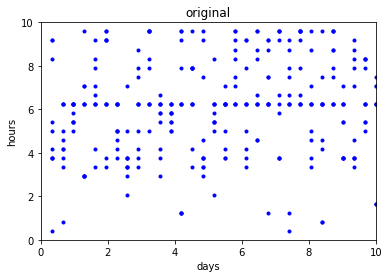

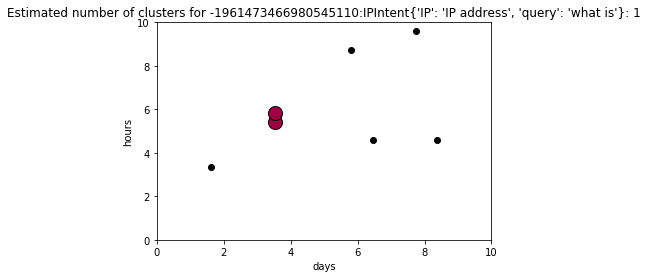

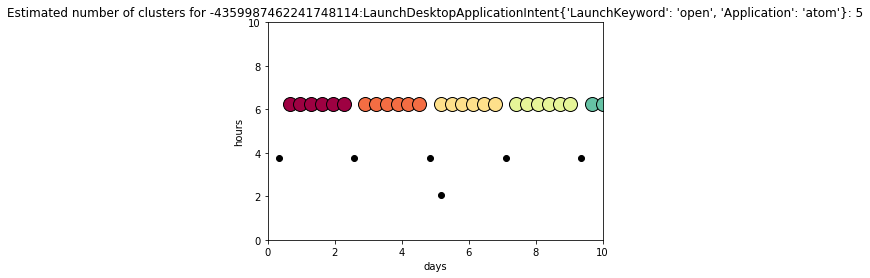

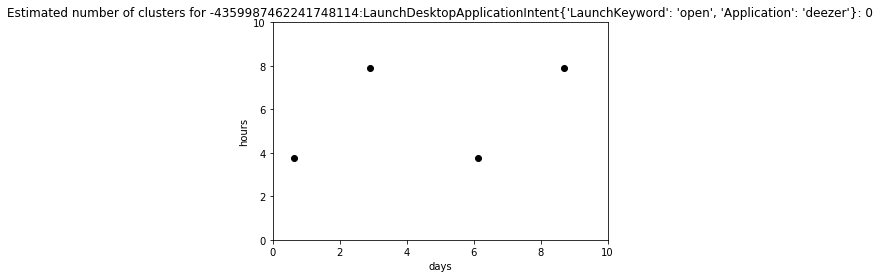

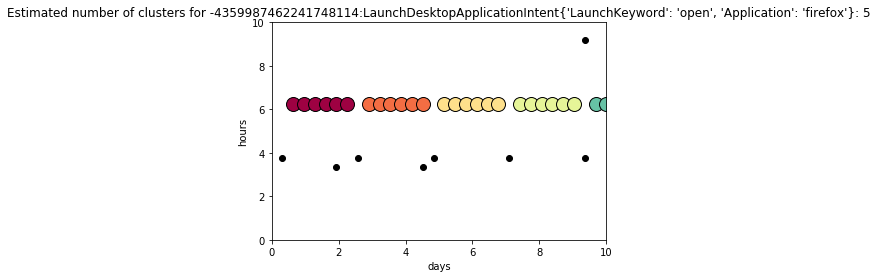

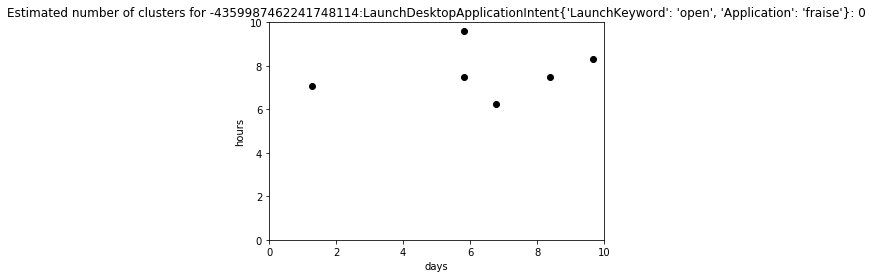

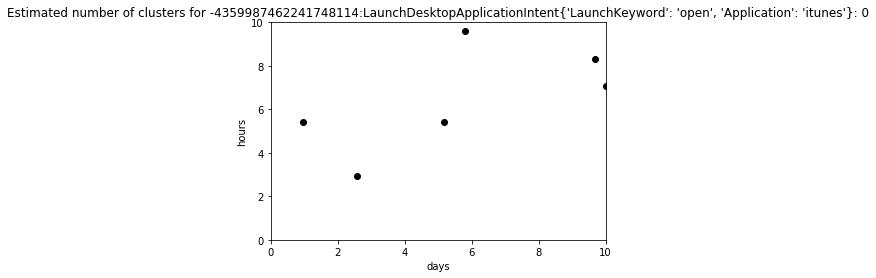

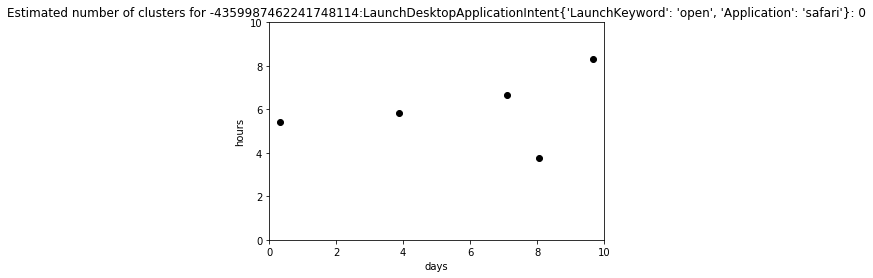

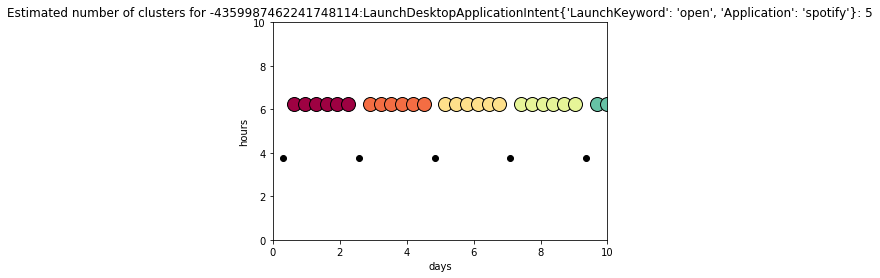

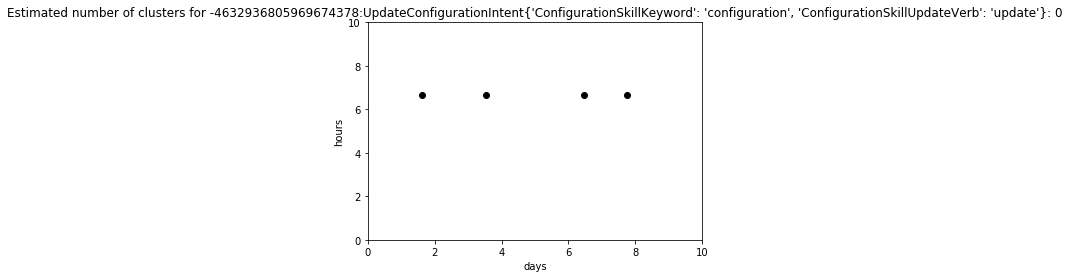

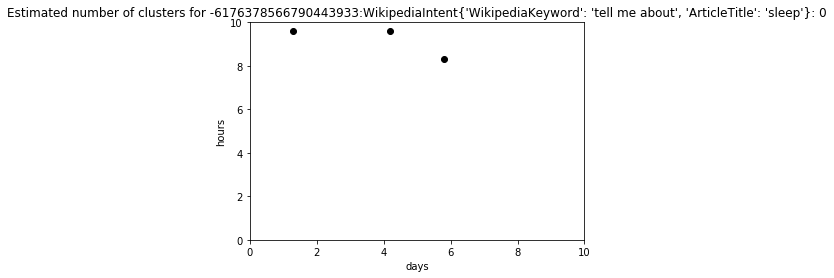

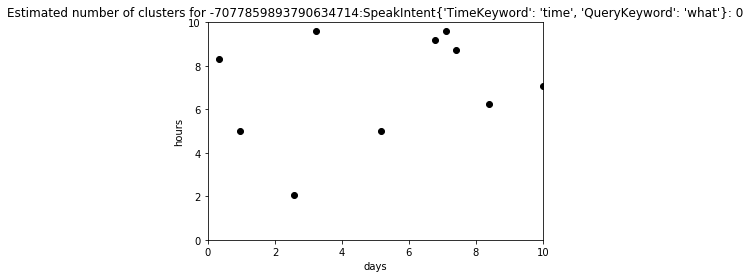

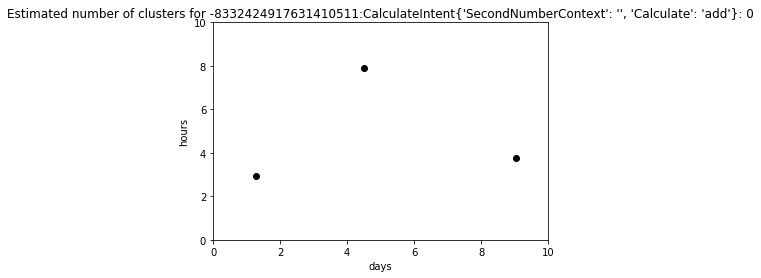

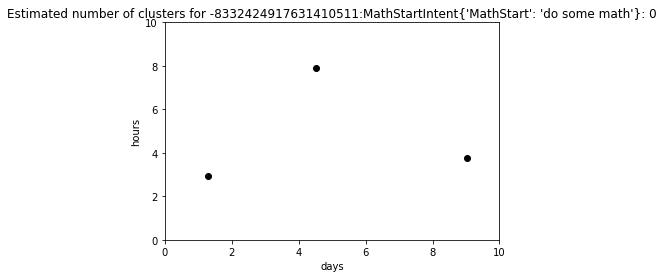

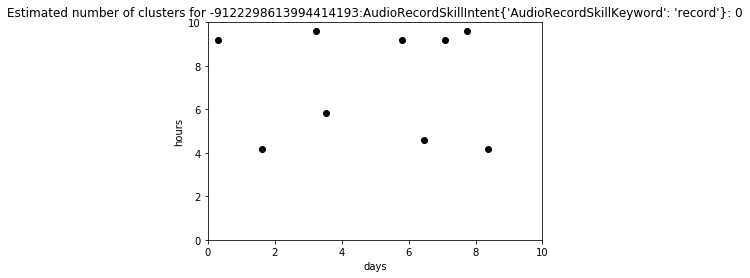

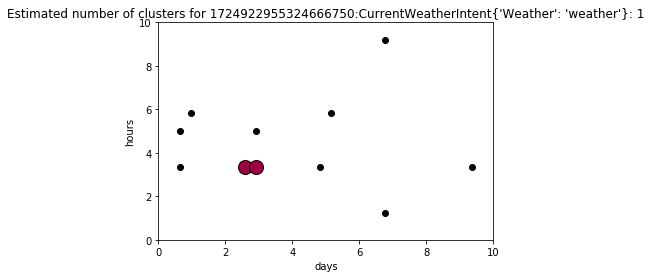

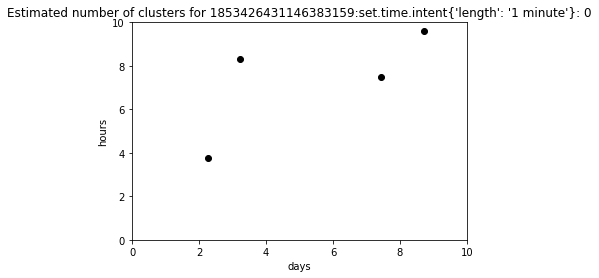

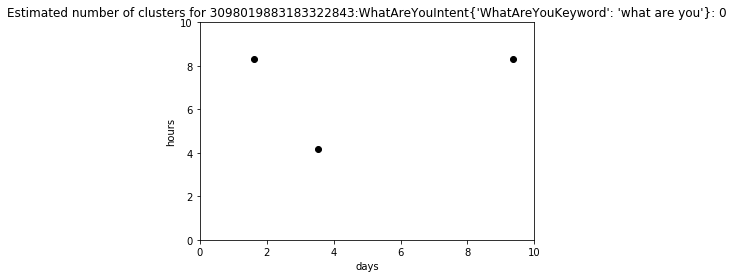

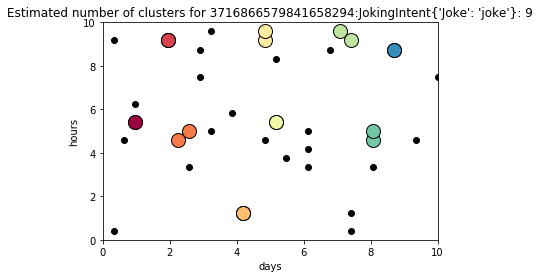

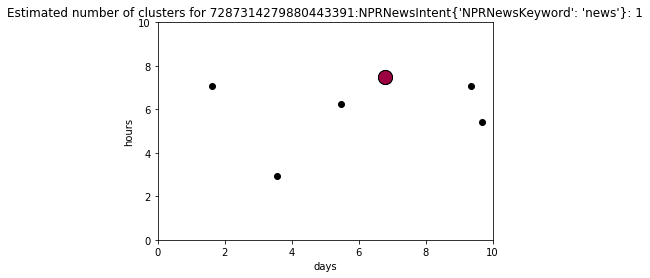

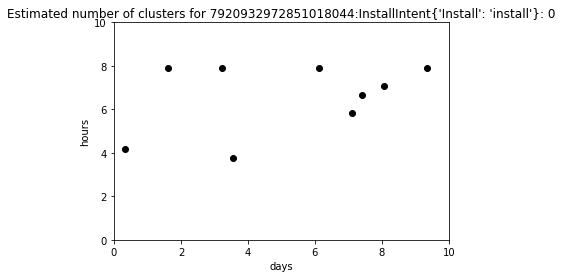

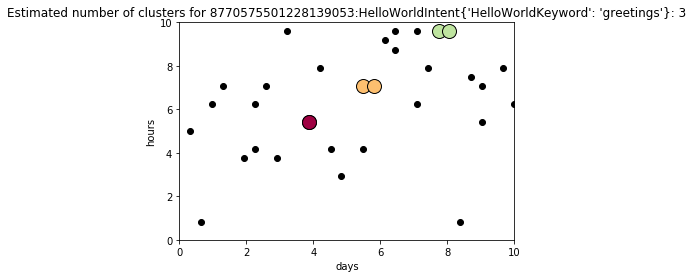

In [21]:
# process affinity propagation and dbscan clustering methods for 120 points
n_samples = 100
process(n_samples)


In [9]:
#We will use DBSCAN for habit mining, as it determines more suitable habits from the groups we can see above
X =gen_dt(20)
X_cluster = X[:, [0, 1]]
print(X_cluster.shape)
print(X)

(20, 3)
(20, 2)
[['5.0' '20.0' '1546735819467345818:Firefox']
 ['25.0' '9.0' '1724922955324666750:CurrentWeatherIntent']
 ['21.0' '9.0' '1724922955324666750:CurrentWeatherIntent']
 ['5.0' '1.0' '3716866579841658294:JokingIntent']
 ['16.0' '2.0' '3716866579841658294:JokingIntent']
 ['29.0' '10.0' '1546735819467345818:Firefox']
 ['4.0' '21.0' '1724922955324666750:CurrentWeatherIntent']
 ['12.0' '22.0' '1546735819467345818:Firefox']
 ['3.0' '14.0' '1546735819467345818:Firefox']
 ['19.0' '13.0' '4253483654314684618:Atom']
 ['31.0' '2.0' '1546735819467345818:Firefox']
 ['12.0' '13.0' '3716866579841658294:JokingIntent']
 ['13.0' '11.0' '1724922955324666750:CurrentWeatherIntent']
 ['7.0' '12.0' '3716866579841658294:JokingIntent']
 ['30.0' '12.0' '1724922955324666750:CurrentWeatherIntent']
 ['25.0' '14.0' '1724922955324666750:CurrentWeatherIntent']
 ['12.0' '9.0' '1724922955324666750:CurrentWeatherIntent']
 ['22.0' '2.0' '1724922955324666750:CurrentWeatherIntent']
 ['7.0' '20.0' '1546735819467